In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

from sklearn.linear_model import LinearRegression

In [2]:
# locations that we are interested in
locations_of_interest = ['Quebec', 'Ontario']

In [3]:
# Load the ev raw data
ev_data_base = pd.read_csv('data/ev.csv')

# convert the REF_DATE to a datetime object
ev_data_base['REF_DATE'] = pd.to_datetime(ev_data_base['REF_DATE'])
ev_data_base.rename(columns={'REF_DATE': 'date', 'VALUE': 'value'}, inplace=True)
all_locations = ev_data_base["GEO"].unique()
# make sure no typo
assert all([loc in all_locations for loc in locations_of_interest]), "One of the locations is not in the data"

ev_data_qc = ev_data_base[ev_data_base['GEO'] == locations_of_interest[0]][['date', 'value']]
ev_data_on = ev_data_base[ev_data_base['GEO'] == locations_of_interest[1]][['date', 'value']]

# scaler = MinMaxScaler()
scaler = StandardScaler()
ev_data_qc_scaled = scaler.fit_transform(ev_data_qc['value'].values.reshape(-1, 1))
ev_data_on_scaled = scaler.fit_transform(ev_data_on['value'].values.reshape(-1, 1))

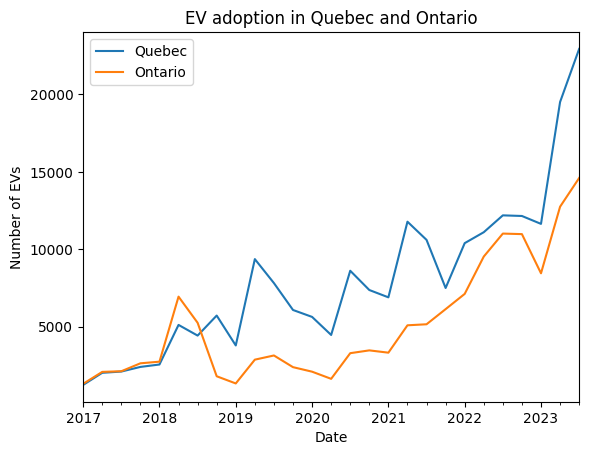

In [4]:
# time series plot of the ev adoption
fig, ax = plt.subplots()
ev_data_qc.plot(x='date', y='value', ax=ax, label=locations_of_interest[0])
ev_data_on.plot(x='date', y='value', ax=ax, label=locations_of_interest[1])
ax.set_ylabel('Number of EVs')
ax.set_xlabel('Date')
ax.set_title('EV adoption in Quebec and Ontario')
plt.show()


In [5]:
# load Quebec air quality data
qc_aq_16_18 = pd.read_csv('data/Quebec/2016-2018.csv')
qc_aq_19_21 = pd.read_csv('data/Quebec/2019-2021.csv')
qc_aq_22_24 = pd.read_csv('data/Quebec/2022-2024.csv')

qc_aq_base = pd.concat([qc_aq_16_18, qc_aq_19_21, qc_aq_22_24])
qc_aq_base.rename(columns={
    'polluant': 'pollutant',
    'valeur': 'value',
    'heure': 'hour'}, inplace=True)

qc_aq_base['date'] = pd.to_datetime(qc_aq_base['date'])
# drop the station and hour columns
qc_aq_base = qc_aq_base.drop(columns=['stationId', 'hour'])
# filter out all the non-numeric values
qc_aq_base = qc_aq_base[qc_aq_base['value'].apply(lambda x: str(x).isnumeric())]

qc_aq={}
for pollutant in qc_aq_base['pollutant'].unique():
    qc_aq[pollutant] = qc_aq_base[qc_aq_base['pollutant'] == pollutant][['date', 'value']].groupby('date').mean()


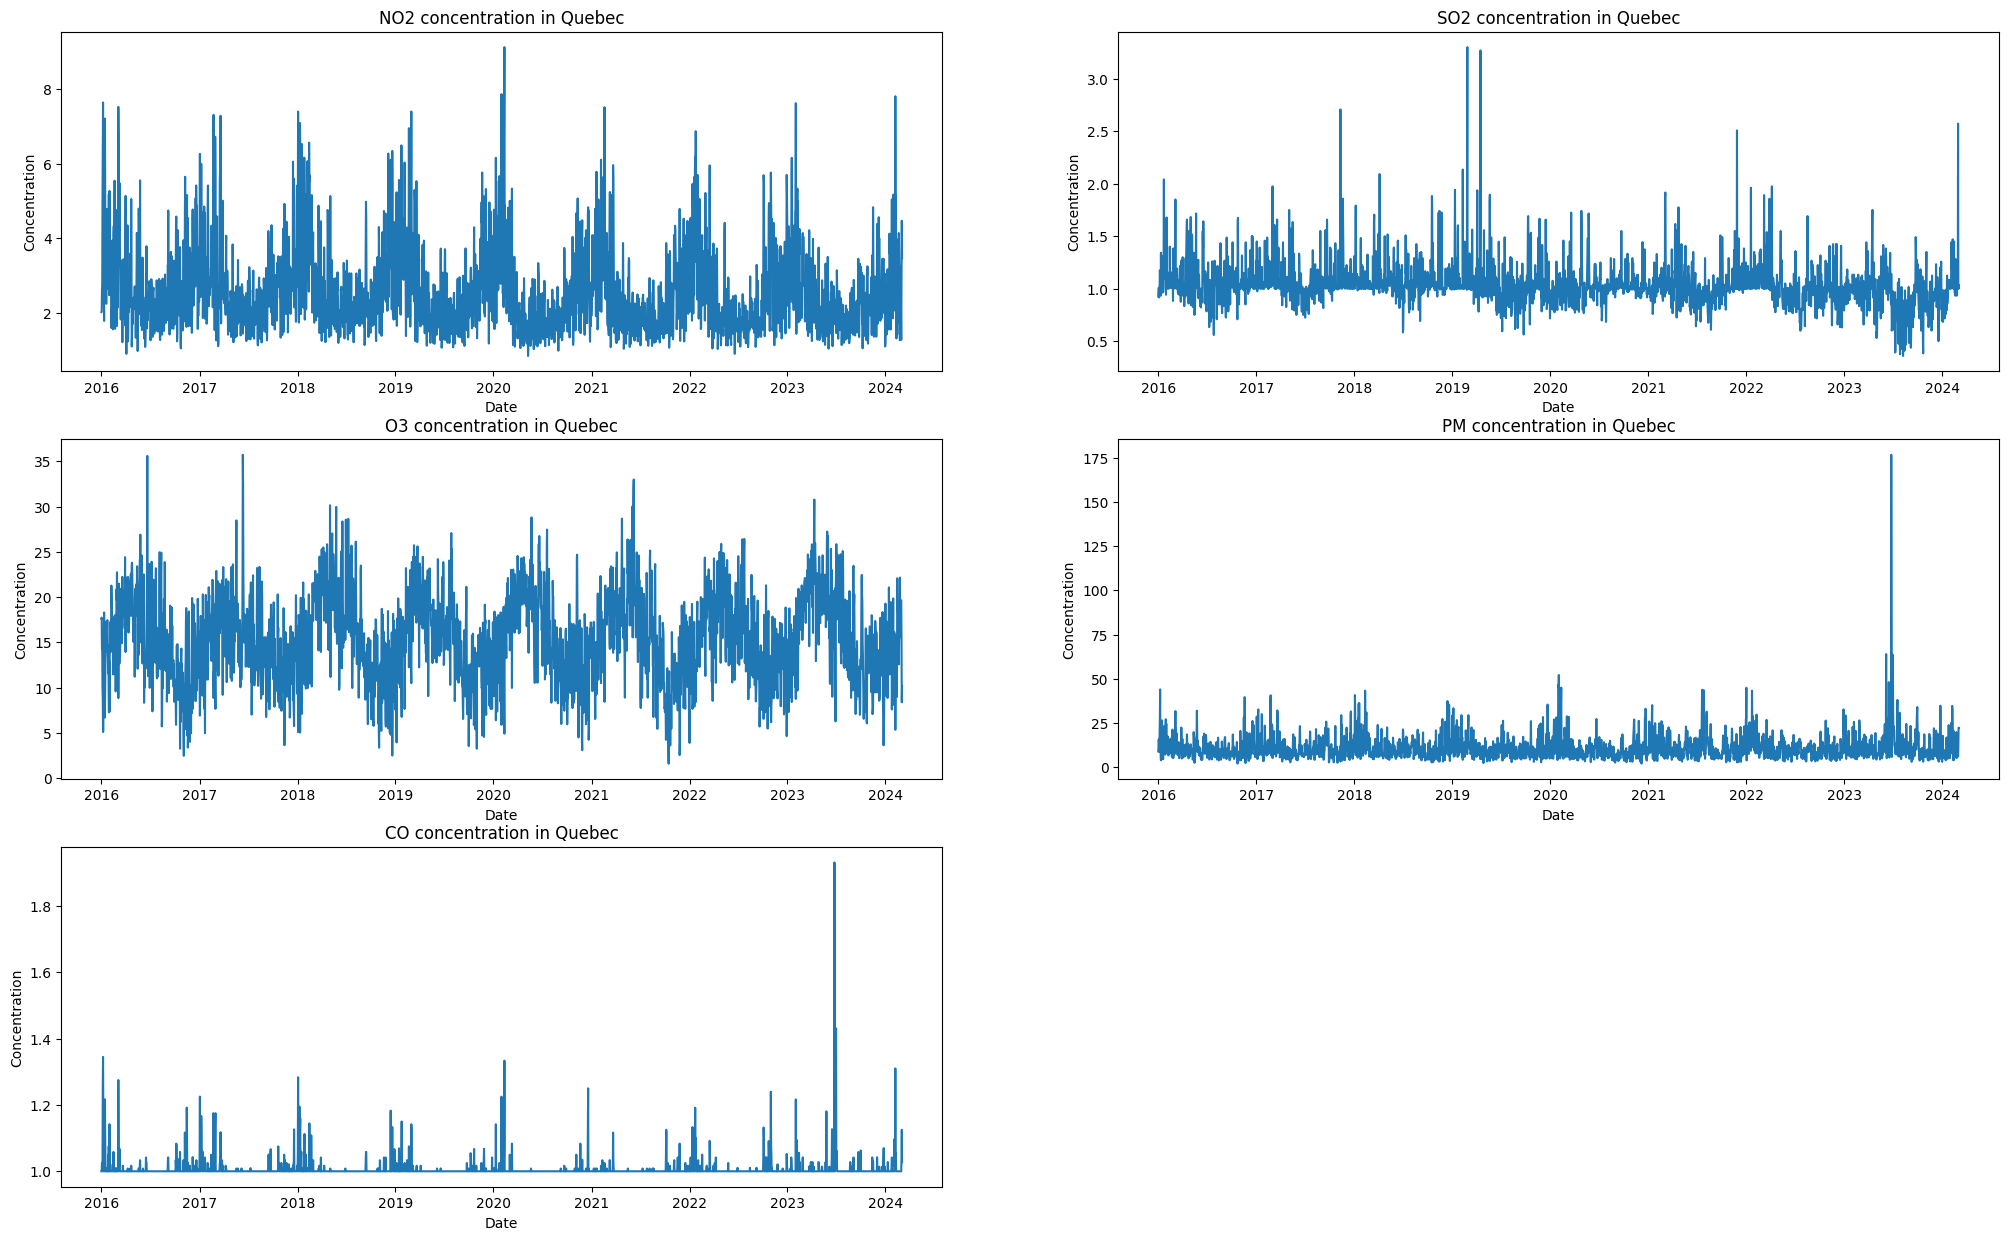

In [6]:
# qc_aq["NO2"]['value'] = np.ones(len(qc_aq["NO2"]['value']))
#time series plot for each pollutant, 2*3 subplots
plt.figure(figsize=(25, 15))
for i in range(len(qc_aq)):
    plt.subplot(3, 2, i+1)
    plt.plot(qc_aq[list(qc_aq.keys())[i]])
    plt.title(list(qc_aq.keys())[i] + ' concentration in Quebec')
    plt.xlabel('Date')
    plt.ylabel('Concentration')
plt.show()

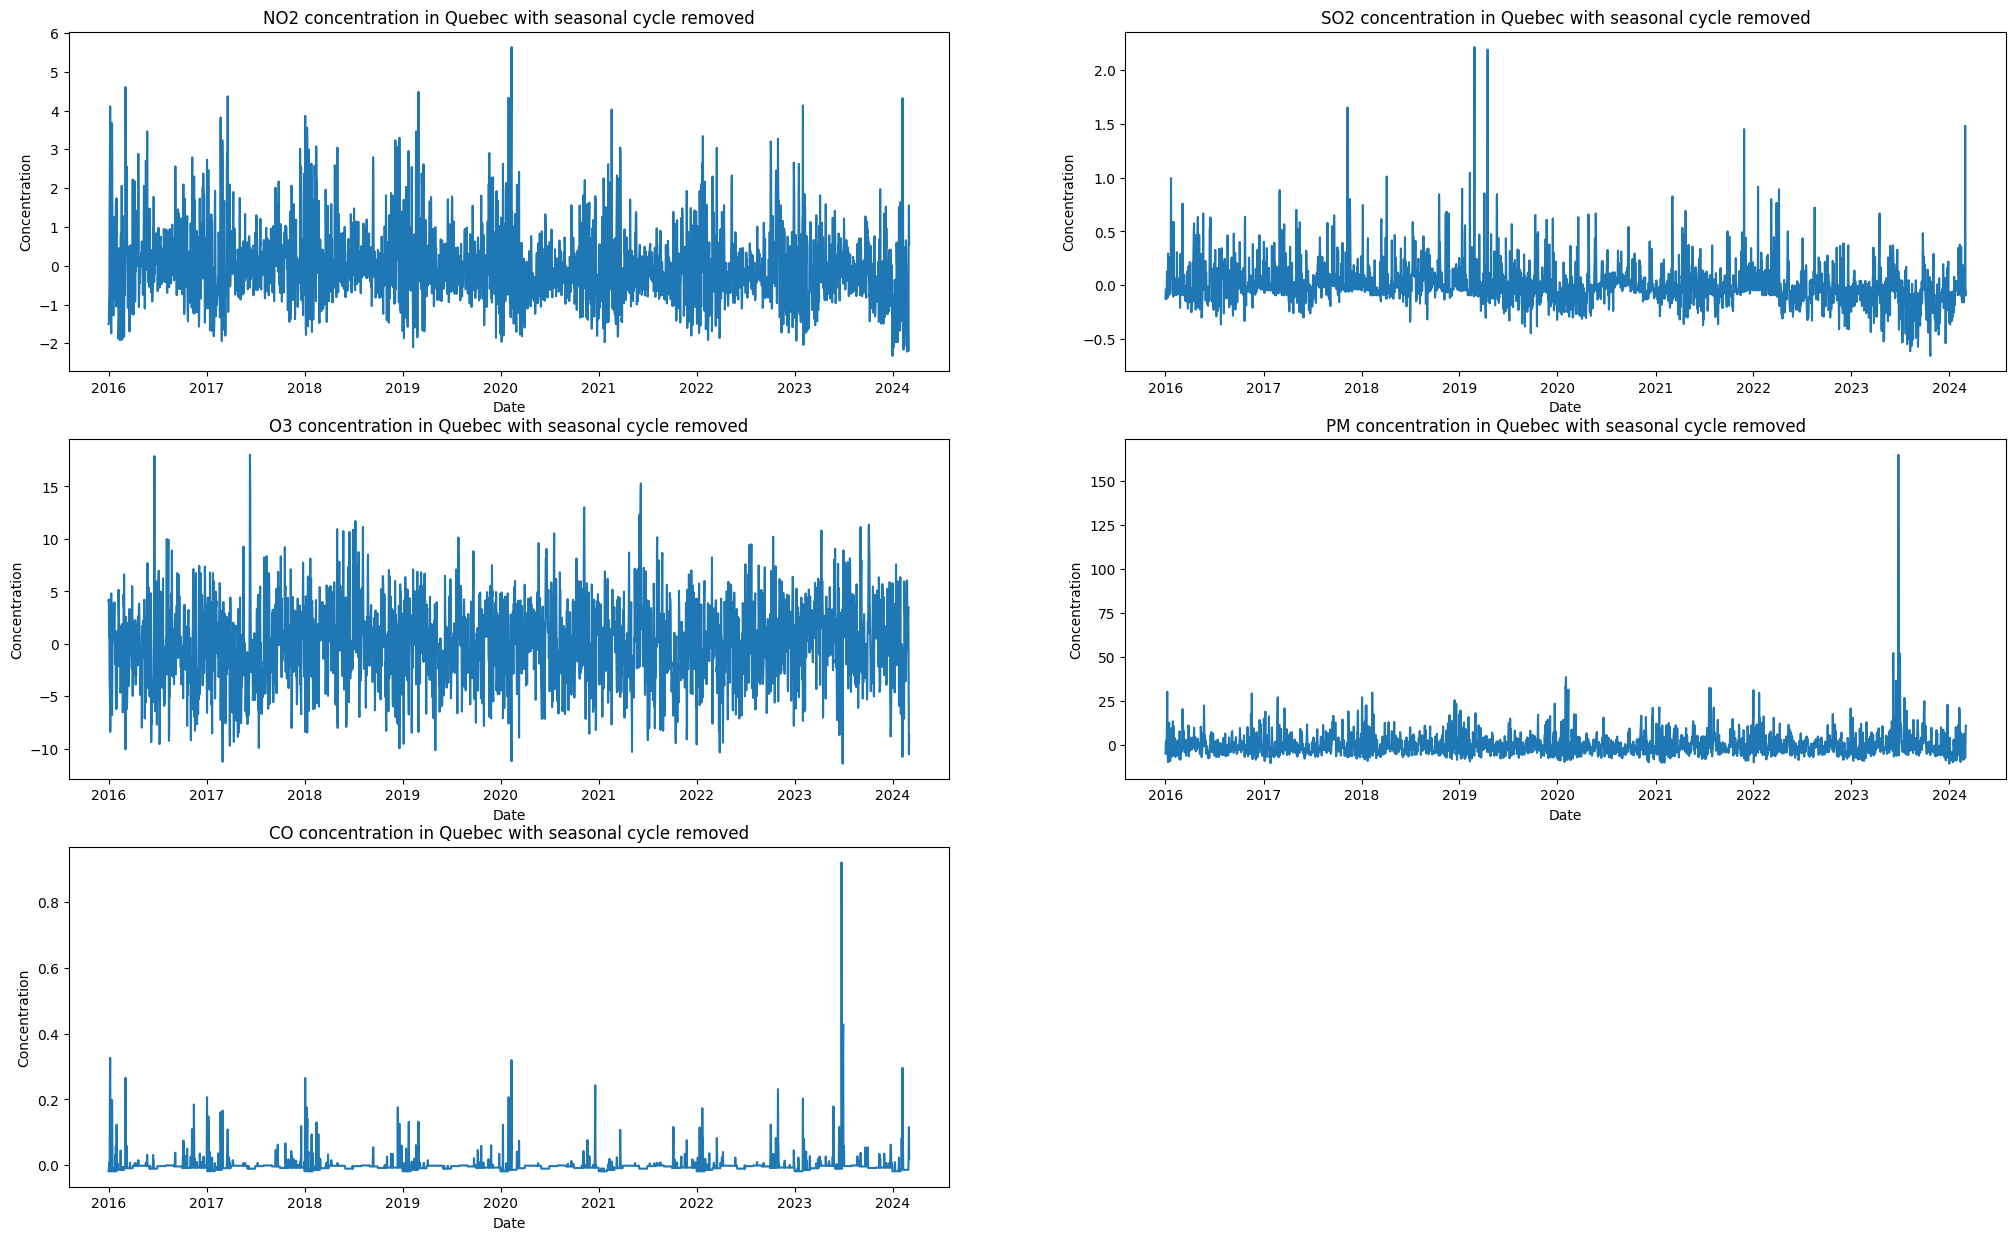

In [7]:
# clear up the seasonal cycle
def remove_seasonal_cycle(df):
    # df contains a date and a value column
    offsets = np.array(df.groupby(df.index.month).mean())
    for i in range(len(offsets)):
        df.loc[df.index.month == i+1, 'value'] -= offsets[i]
    return df

qc_aq_removed_seasonal_var = qc_aq.copy()

for pollutant in qc_aq_removed_seasonal_var:
    qc_aq_removed_seasonal_var[pollutant] = remove_seasonal_cycle(qc_aq_removed_seasonal_var[pollutant])

#time series plot for each pollutant, 2*3 subplots
plt.figure(figsize=(25, 15))
for i in range(len(qc_aq_removed_seasonal_var)):
    plt.subplot(3, 2, i+1)
    plt.plot(qc_aq_removed_seasonal_var[list(qc_aq_removed_seasonal_var.keys())[i]])
    plt.title(list(qc_aq_removed_seasonal_var.keys())[i] + ' concentration in Quebec with seasonal cycle removed')
    plt.xlabel('Date')
    plt.ylabel('Concentration')
plt.show()

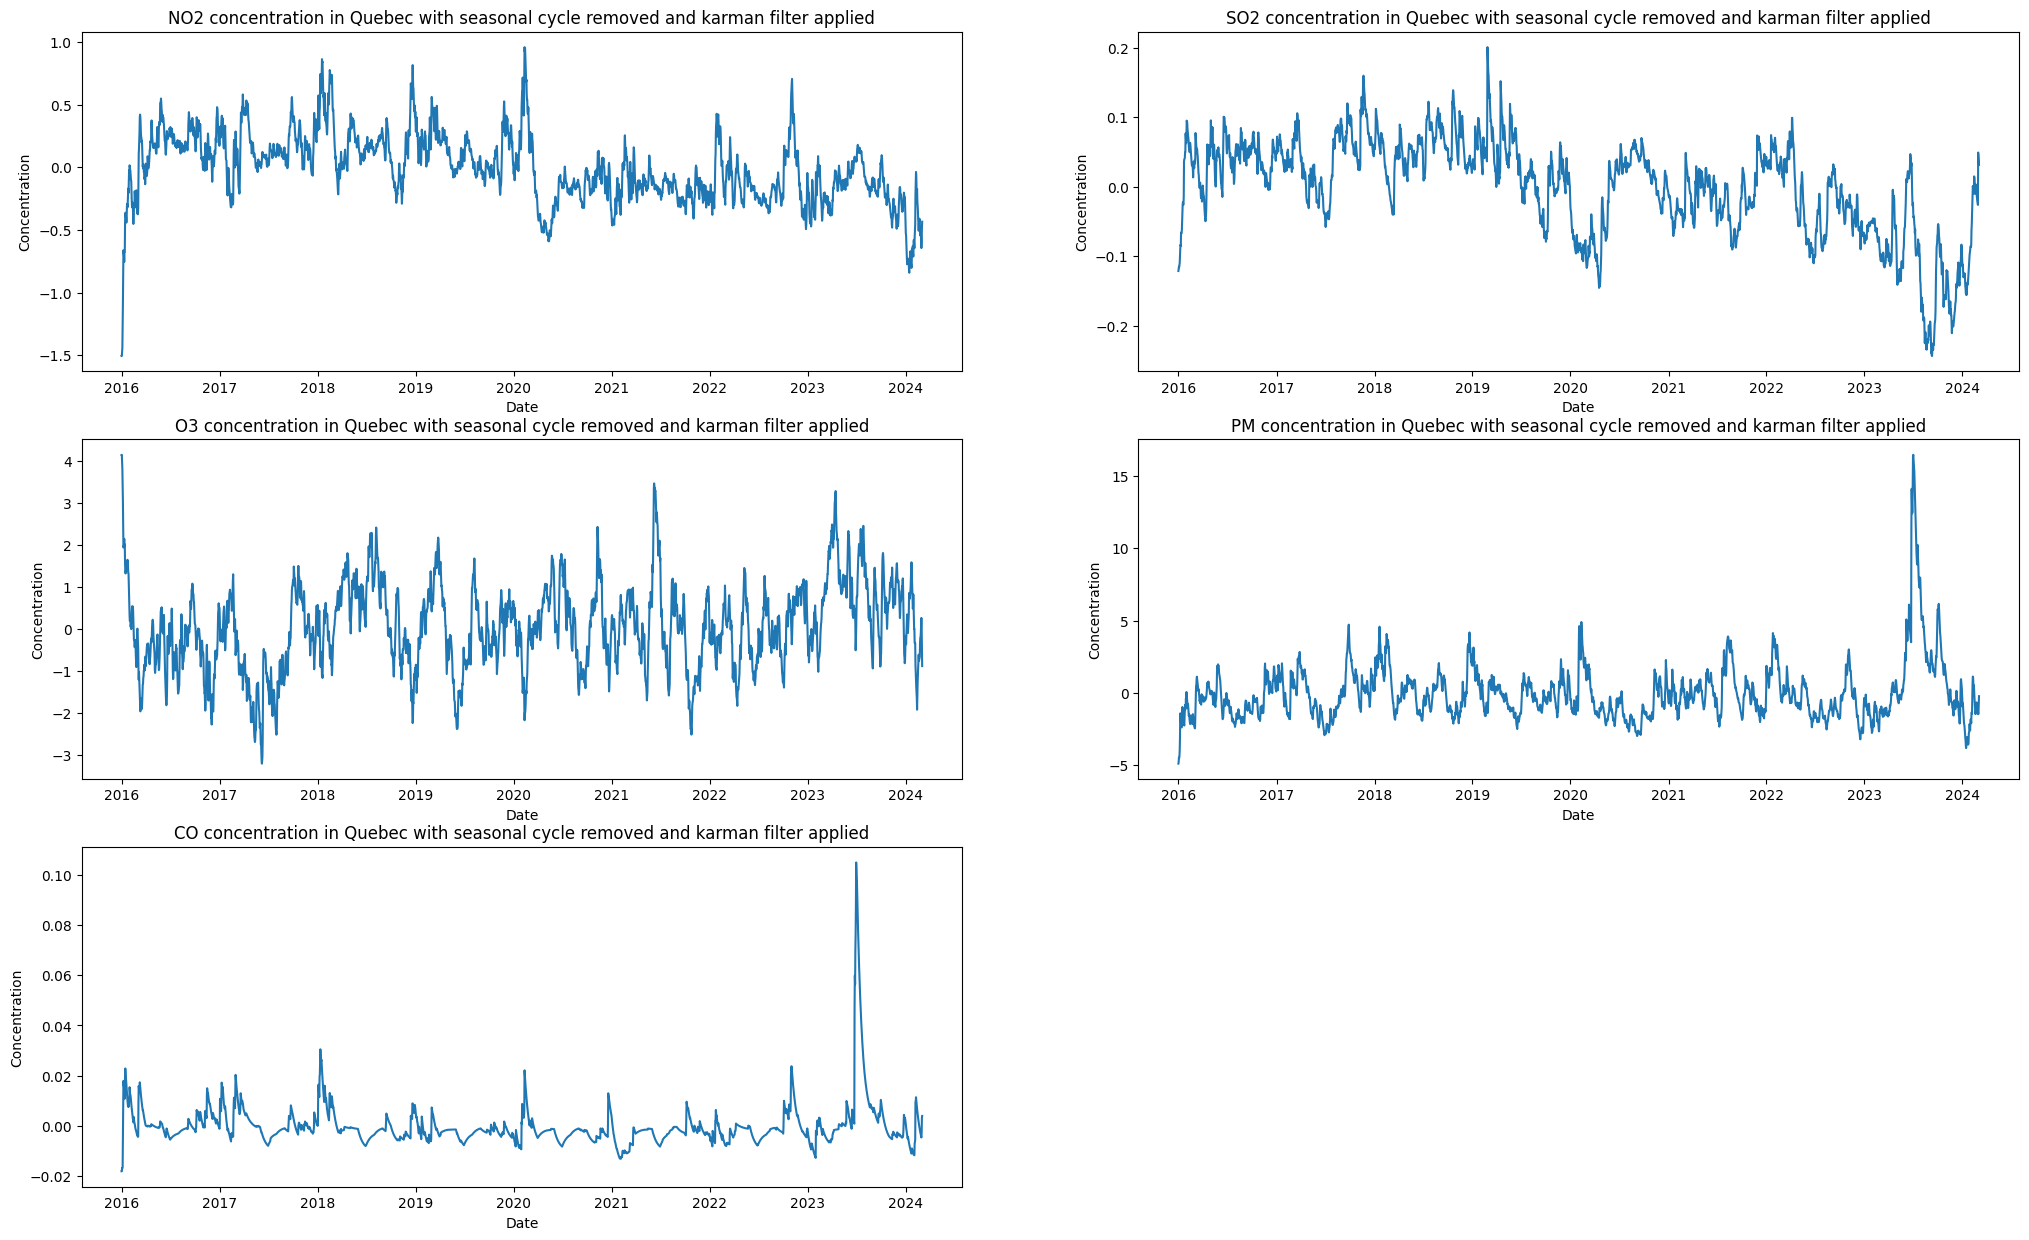

In [8]:
# apply karman filter to the qc_aq data
def after_karman(d, n_iter=1):
    d = np.array(d)
    for i in range(n_iter):
        last = d[0]
        for j in range(1, len(d)):
            d[j] = last*0.95 + d[j]*0.05
            last = d[j]
    return d

qc_aq_karman = qc_aq_removed_seasonal_var.copy()

for pollutant in qc_aq_karman:
    qc_aq_karman[pollutant]['value'] = after_karman(qc_aq_karman[pollutant]['value'])

#time series plot for each pollutant, 2*3 subplots
plt.figure(figsize=(25, 15))
for i in range(len(qc_aq_karman)):
    plt.subplot(3, 2, i+1)
    plt.plot(qc_aq_karman[list(qc_aq_karman.keys())[i]])
    plt.title(list(qc_aq_karman.keys())[i] + ' concentration in Quebec with seasonal cycle removed and karman filter applied')
    plt.xlabel('Date')
    plt.ylabel('Concentration')
plt.show()


C:\Users\priva\AppData\Local\Temp\ipykernel_5732\2551845049.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qc_aq_karman_trimmed[pollutant]['value'] = scaler.fit_transform(qc_aq_karman_trimmed[pollutant]['value'].values.reshape(-1, 1))
C:\Users\priva\AppData\Local\Temp\ipykernel_5732\2551845049.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qc_aq_karman_trimmed[pollutant]['value'] = scaler.fit_transform(qc_aq_karman_trimmed[pollutant]['value'].values.reshape(-1, 1))
C:\Users\priva\AppData\Local\Tem

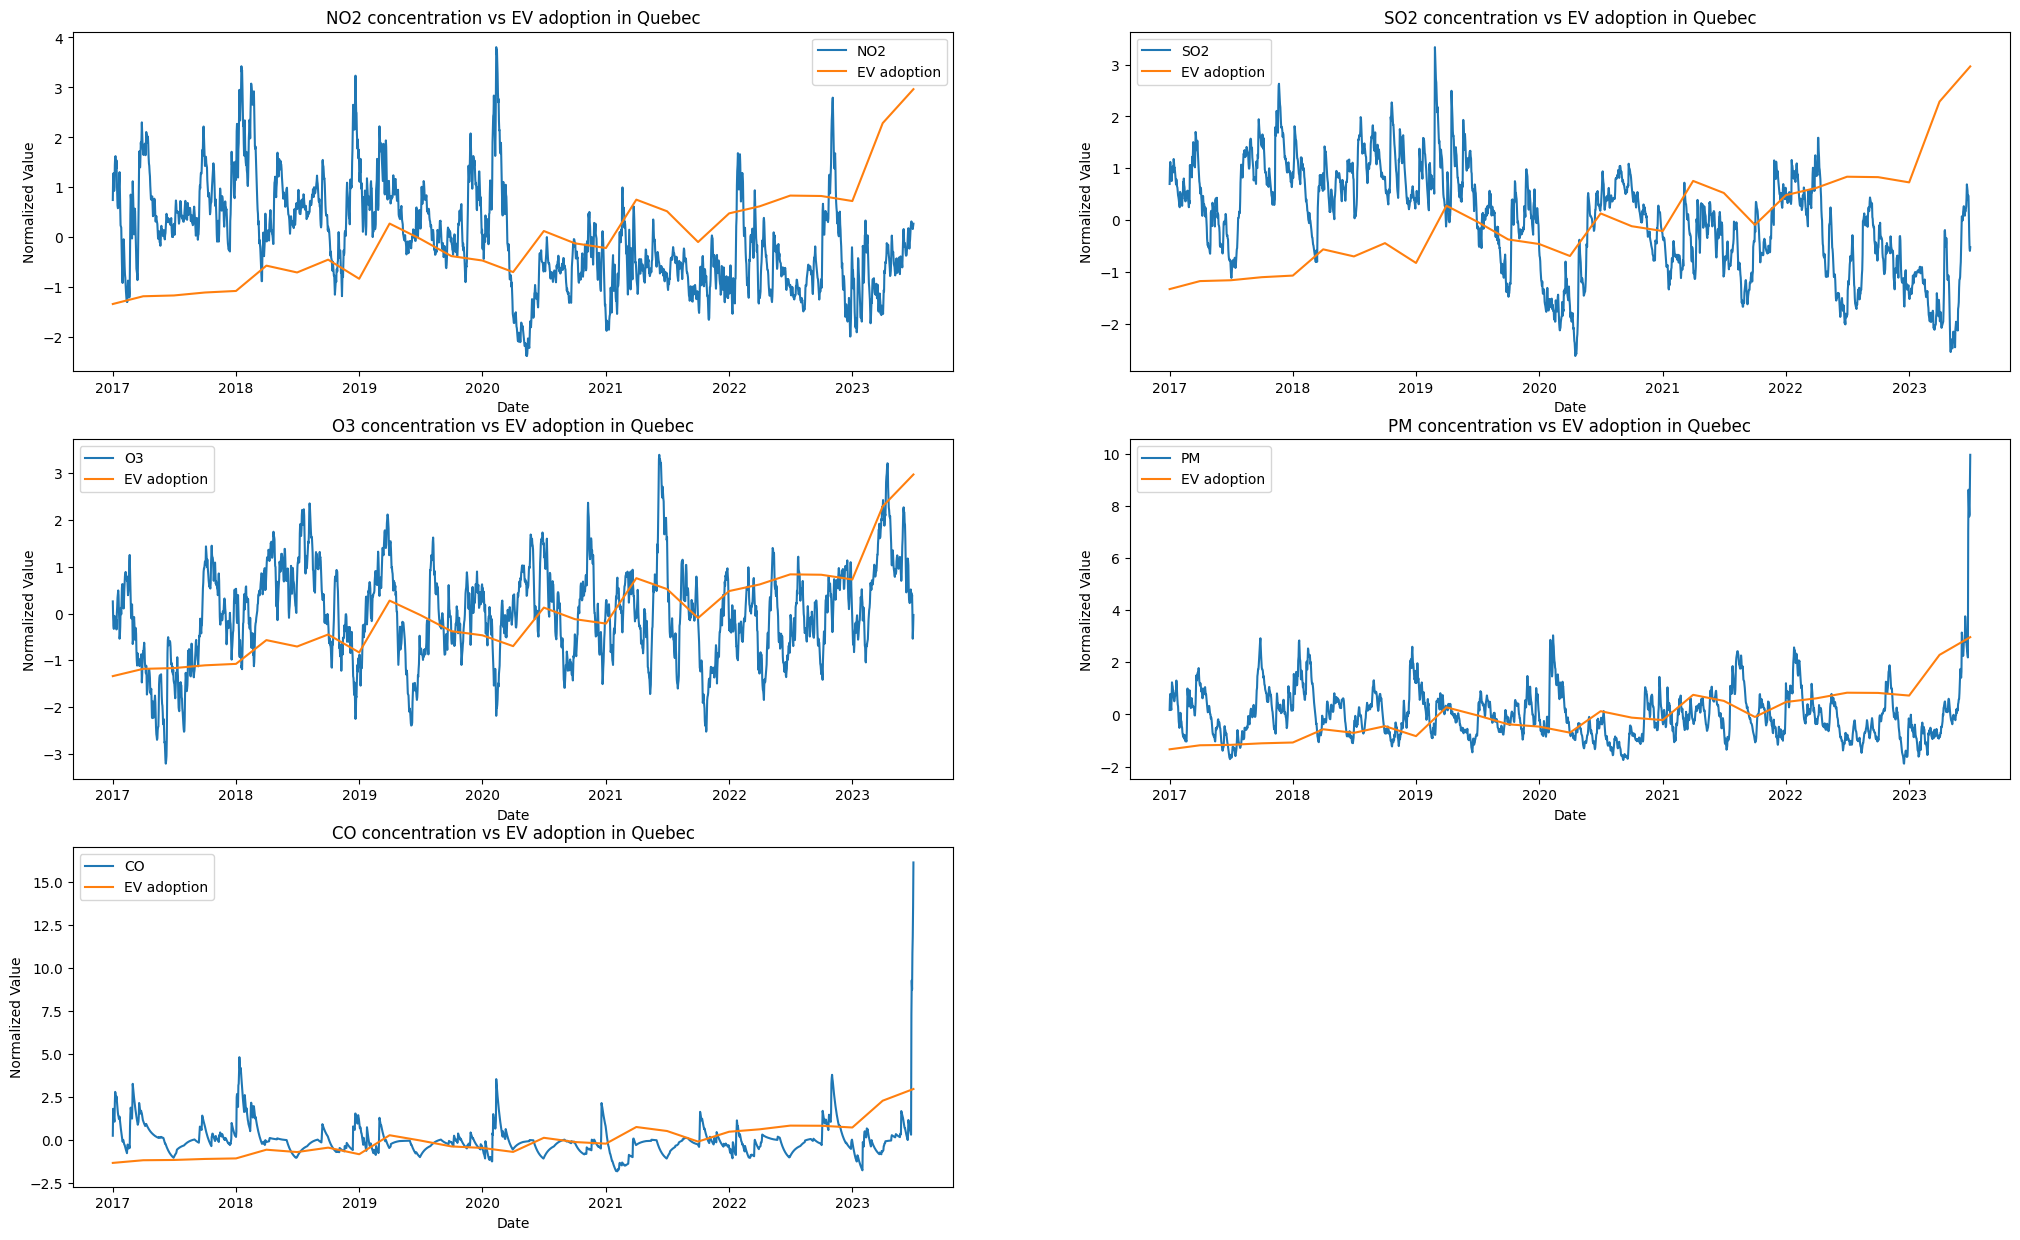

In [9]:
qc_ev_time_range = (ev_data_qc['date'].min(), ev_data_qc['date'].max())
# trim the qc_aq_karman data to the same time range as the ev data
qc_aq_karman_trimmed = {}
for pollutant in qc_aq_karman:
    qc_aq_karman_trimmed[pollutant] = qc_aq_karman[pollutant][qc_ev_time_range[0]:qc_ev_time_range[1]]

# scale the qc_aq_karman data
for pollutant in qc_aq_karman_trimmed:
    qc_aq_karman_trimmed[pollutant]['value'] = scaler.fit_transform(qc_aq_karman_trimmed[pollutant]['value'].values.reshape(-1, 1))

# plot the time series of the scaled data
plt.figure(figsize=(25, 15))
for i in range(len(qc_aq_karman_trimmed)):
    plt.subplot(3, 2, i+1)
    plt.plot(qc_aq_karman_trimmed[list(qc_aq_karman_trimmed.keys())[i]], label=list(qc_aq_karman_trimmed.keys())[i])
    plt.plot(ev_data_qc['date'], ev_data_qc_scaled, label='EV adoption')
    plt.title(list(qc_aq_karman.keys())[i] + ' concentration vs EV adoption in Quebec')
    plt.xlabel('Date')
    plt.ylabel('Normalized Value')
    plt.legend()
plt.show()


[-0.34186756946287694, array([-0.68834874,  0.0046136 ]), 0.14176320236862594]
[-0.36033578801938065, array([-0.68515902, -0.03551255]), 0.1727299905361518]
[0.1919437953687271, array([-0.15182087,  0.53570846]), 0.05023887705799868]
[0.9944138324863584, array([0.28075662, 1.70807105]), 0.2477943618670071]
[1.5899164221453752, array([0.46595654, 2.7138763 ]), 0.2534558463707449]


C:\Users\priva\AppData\Local\Temp\ipykernel_5732\3990690885.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qc_aq_karman_trimmed_monthly[pollutant]["time"] = qc_aq_karman_trimmed_monthly[pollutant].index.to_period('M').to_timestamp()
C:\Users\priva\AppData\Local\Temp\ipykernel_5732\3990690885.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qc_aq_karman_trimmed_monthly[pollutant]["time"] = qc_aq_karman_trimmed_monthly[pollutant].index.to_period('M').to_timestamp()
C:\Users\priva\AppData\Local\Temp\ip

<Figure size 640x480 with 0 Axes>

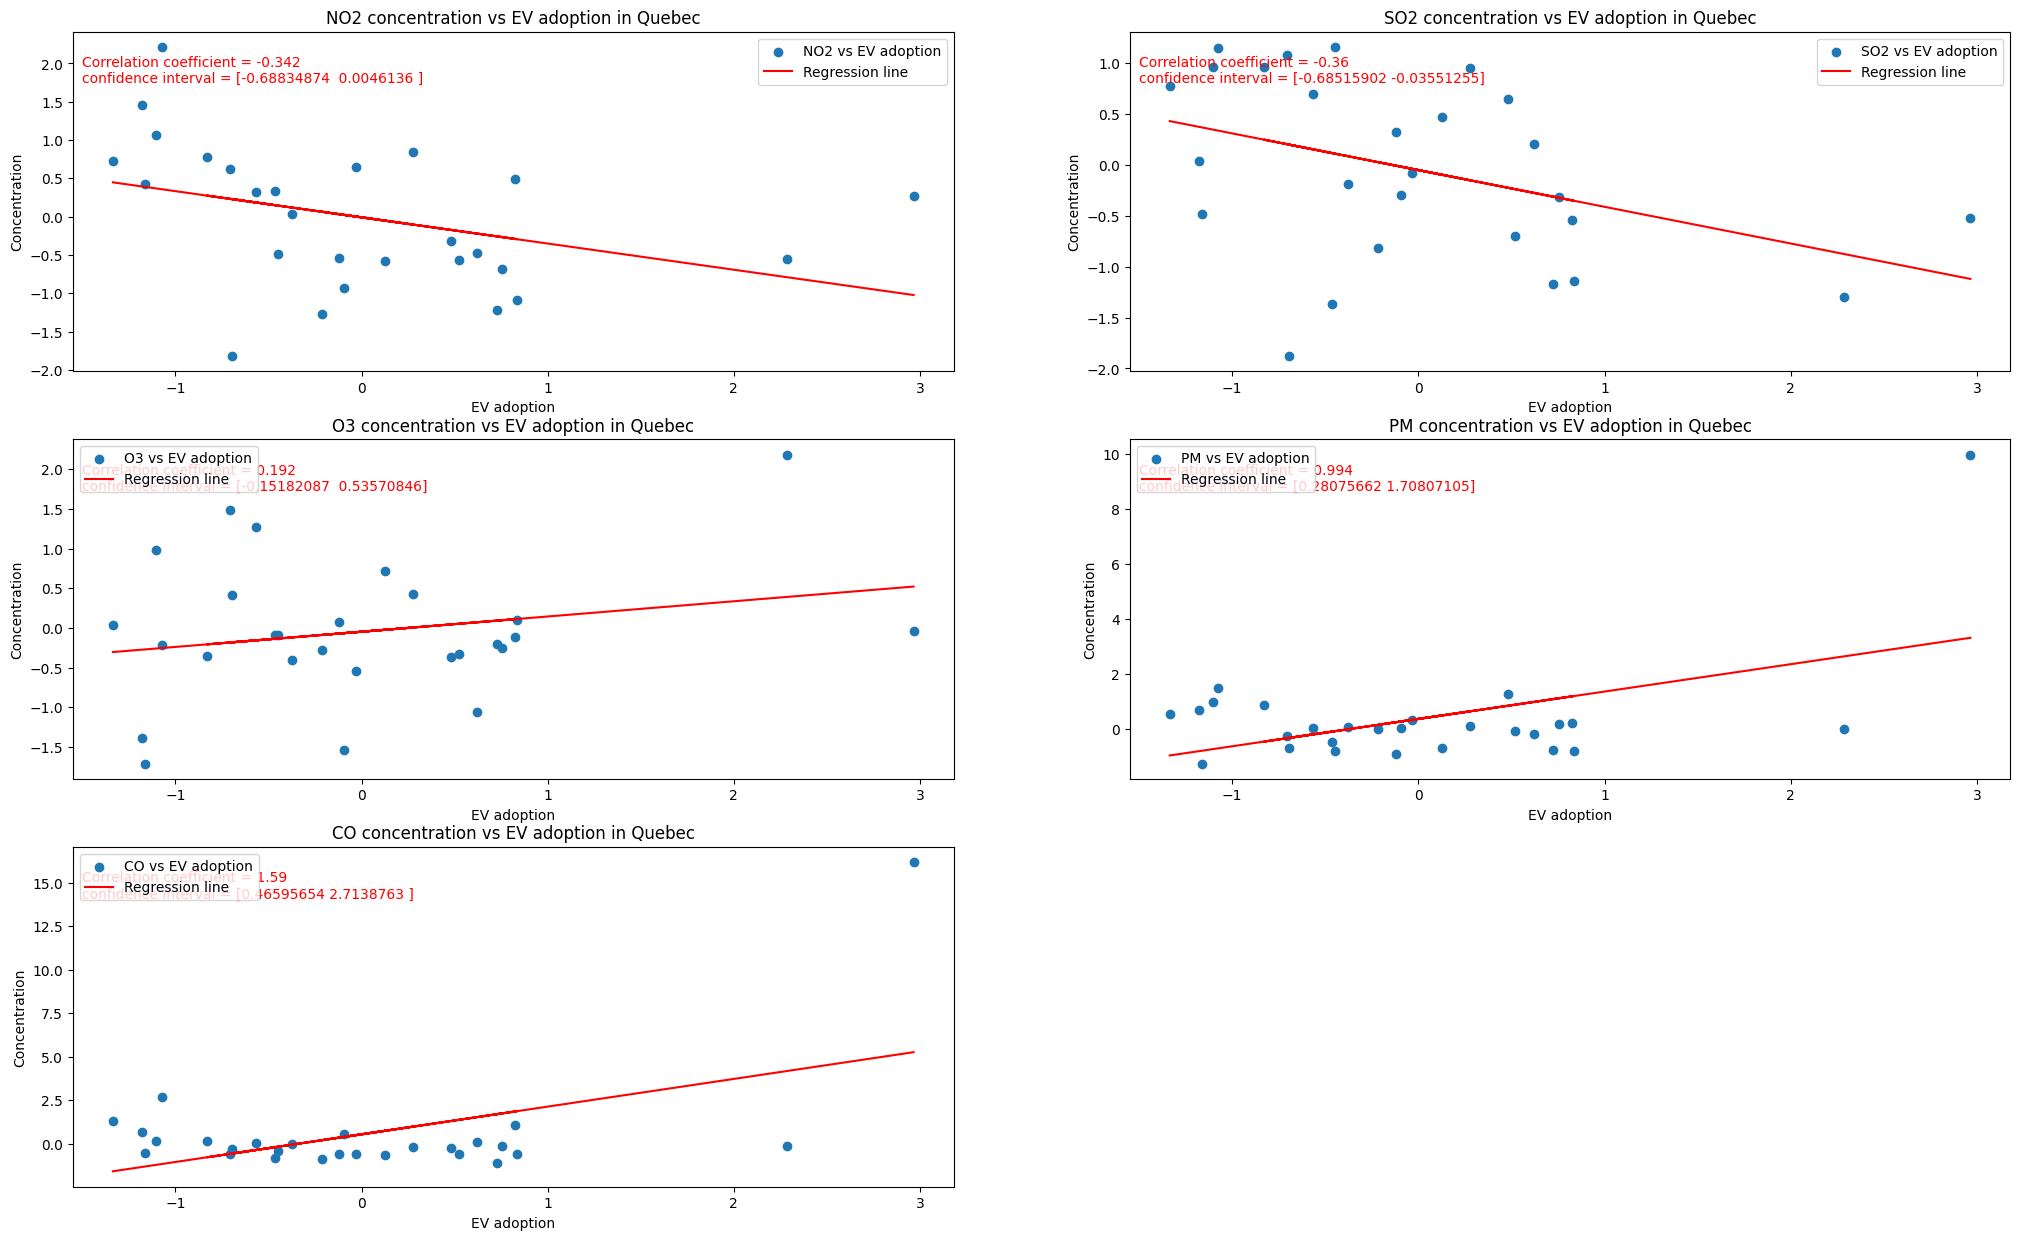

In [10]:
# monthly average of the air quality data
qc_aq_karman_trimmed_monthly = qc_aq_karman_trimmed.copy()
for pollutant in qc_aq_karman_trimmed_monthly:
    # set time to the first day of the month
    qc_aq_karman_trimmed_monthly[pollutant]["time"] = qc_aq_karman_trimmed_monthly[pollutant].index.to_period('M').to_timestamp()

for pollutant in qc_aq_karman_trimmed_monthly:
    qc_aq_karman_trimmed_monthly[pollutant] = qc_aq_karman_trimmed_monthly[pollutant].groupby('time').mean()

# pair the ev data with the air quality data
qc_final_data = qc_aq_karman_trimmed.copy()
for pollutant in qc_final_data:
    qc_final_data[pollutant] = {"x":[], "y":[]}

for pollutant in qc_final_data:
    for i in range(len(ev_data_qc)):
        d = ev_data_qc.iloc[i]['date']
        # get the air quality data for the same month
        air_quality_data = qc_aq_karman_trimmed_monthly[pollutant].loc[d]['value']
        qc_final_data[pollutant]["x"].append(ev_data_qc_scaled[i][0])
        qc_final_data[pollutant]["y"].append(air_quality_data)
        
# plot the pair data
plt.clf()
plt.figure(figsize=(25, 15))
for i, pollutant in enumerate(qc_final_data):
    plt.subplot(3, 2, i+1)
    x = qc_final_data[pollutant]["x"]
    y = qc_final_data[pollutant]["y"]
    plt.scatter(x, y, label=pollutant + ' vs EV adoption')
    plt.title(pollutant + ' concentration vs EV adoption in Quebec')
    plt.xlabel('EV adoption')
    plt.ylabel('Concentration')
    _x = sm.add_constant(x)
    model = sm.OLS(y, _x, missing='drop').fit()
    print([model.params[1], np.array(model.conf_int())[1,:],model.rsquared])
    plt.annotate('Correlation coefficient = ' + str(np.around(model.params[1], decimals=3)) + '\nconfidence interval = ' + str(np.array(model.conf_int())[1,:]), xy=(0.01, 0.85), xycoords='axes fraction', color='r')

    x = np.array(x).reshape(-1,1)
    y = np.array(y).reshape(-1,1)
    # fit a linear model to the training data
    reg = LinearRegression().fit(x, y)

    # get regression line - what values do you need to enter into the function?
    pred = reg.predict(x)

    # remember how we saved the subplot axes earlier? Now we can call them to continue adding to the plots. Like so:
    # plot the ubc_temp regression line
    plt.plot(x, pred, color='r', label='Regression line')
    plt.legend()

plt.show()


